In [22]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_excel('./data.xlsx')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# 假设数据是每日的，设置每日频率
df = df.asfreq('D', method='ffill')  # 使用前向填充处理缺失值

# 检查并去除NaN值
df.dropna(subset=['price'], inplace=True)

# 检查并替换无限值为NaN，然后去除这些值
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['price'], inplace=True)

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

def ADF_PP(x):
    # 进行ADF检验
    adf_test = adfuller(x, autolag='AIC')
    # 如果需要更详细的汇总信息，可以这样做：
    print('ADF Test Result Summary:')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print(f'Number of Lags Used: {adf_test[2]}')
    print(f'Number of Observations Used: {adf_test[3]}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'   {key}, {value}')
    print(f'Maximized Information Criterion (AIC): {adf_test[5]}')
    
    # 进行Phillips-Perron检验
    pp_test = PhillipsPerron(x)
    # pp_output = pd.DataFrame({
    #     'PP Test Statistic': [pp_test.stat],
    #     'p-value': [pp_test.pvalue],
    #     '#Lags Used': [pp_test.lags],
    #     'Number of Observations Used': [pp_test.nobs]
    # })
    # for key, value in pp_test.critical_values.items():
    #     pp_output[f'Critical Value ({key})'] = value
    # 
    # # 打印ADF检验结果

    # 打印Phillips-Perron检验结果
    print('Phillips-Perron Test for unit root')
    print(pp_test.summary())


In [24]:
ADF_PP(df['price'])

ADF Test Result Summary:
ADF Statistic: -2.4183804337627026
p-value: 0.13661572567400726
Number of Lags Used: 24
Number of Observations Used: 1436
Critical Values:
   1%, -3.434911997169608
   5%, -2.863554810504947
   10%, -2.567842671398422
Maximized Information Criterion (AIC): -4178.564359907858
Phillips-Perron Test for unit root
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.111
P-value                         0.240
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<Figure size 640x480 with 0 Axes>

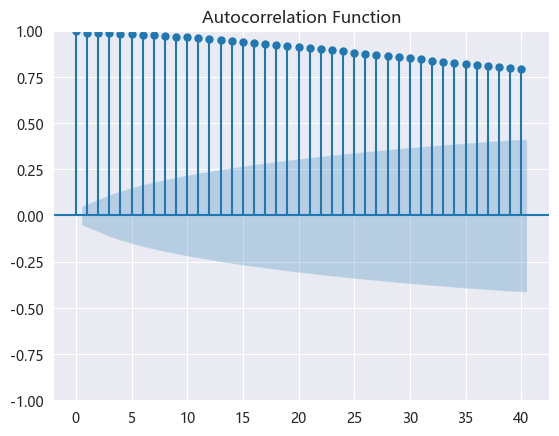

<Figure size 640x480 with 0 Axes>

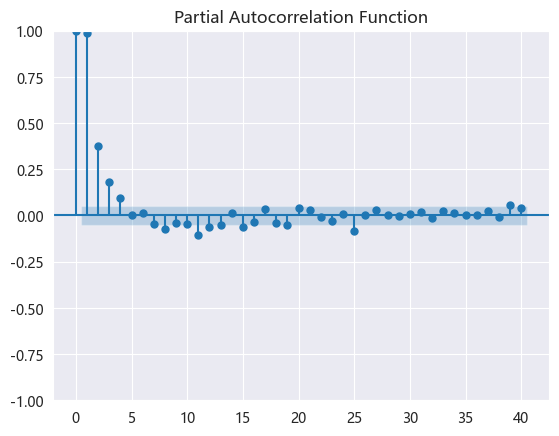

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 绘制自相关图
plt.figure()
plot_acf(df['price'], lags=40)  # 可以通过lags参数调整显示的滞后数量
plt.title('Autocorrelation Function')

# 绘制偏自相关图
plt.figure()
plot_pacf(df['price'], lags=40)  # 同样可以调整滞后数量
plt.title('Partial Autocorrelation Function')

# 显示图形
plt.show()


In [26]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

def zixiangguan_pianxiangguan(price_series):
    # 计算ACF和PACF值
    lags = 10  # 可以根据需要修改滞后期数
    acf_vals = acf(price_series, nlags=lags, fft=False)
    pacf_vals = pacf(price_series, nlags=lags, method='ols')
    
    # 计算Ljung-Box Q统计量
    acorr_table = acorr_ljungbox(price_series, lags=range(1, lags+1), return_df=False)
    # 构建表格
    acf_pacf_table = pd.DataFrame({
        'LAG': range(1, lags+1),
        'AC': acf_vals[1:],  # 第一个值是滞后0，通常不包括
        'PAC': pacf_vals[1:],  # 同上
    })

    print(acf_pacf_table)
    print(acorr_table)

In [27]:
zixiangguan_pianxiangguan(df['price'])

   LAG        AC       PAC
0    1  0.989948  0.990089
1    2  0.987473  0.379752
2    3  0.985281  0.188113
3    4  0.983218  0.098753
4    5  0.980378  0.008548
5    6  0.978060  0.013971
6    7  0.974763 -0.053955
7    8  0.971043 -0.082846
8    9  0.967623 -0.049946
9   10  0.963804 -0.056911
         lb_stat  lb_pvalue
1    1434.718398        0.0
2    2863.250785        0.0
3    4286.421047        0.0
4    5704.612253        0.0
5    7115.591479        0.0
6    8520.870892        0.0
7    9917.652507        0.0
8   11304.746610        0.0
9   12683.035310        0.0
10  14051.409327        0.0


In [28]:
# 拟合ARIMA模型
arima_model = ARIMA(df['price'], order=(3, 0, 0))
arima_result = arima_model.fit()
# 输出模型摘要
print(arima_result.summary())

# 使用ARIMA模型预测价格P和计算残差
df['P'] = arima_result.predict(start=df.index[0], end=df.index[-1])
df['res'] = df['price'] - df['P']  # 直接计算残差

# 对残差进行缩放，以提高模型拟合过程的稳定性
df['res_scaled'] = df['res'] * 10  # 缩放因子为10

# 使用残差及其外生变量拟合GARCH(1,1)模型
garch_model = arch_model(df['res_scaled'], mean='ARX', lags=[1], vol='Garch', p=1, q=1, dist='Normal')
garch_result = garch_model.fit(disp='off')



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1461
Model:                 ARIMA(3, 0, 0)   Log Likelihood                2107.533
Date:                Wed, 21 Feb 2024   AIC                          -4205.067
Time:                        19:40:08   BIC                          -4178.633
Sample:                    01-01-2020   HQIC                         -4195.206
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5752      0.292      8.811      0.000       2.002       3.148
ar.L1          0.5426      0.014     38.644      0.000       0.515       0.570
ar.L2          0.2643      0.016     16.600      0.0

In [29]:


# 假设arima_result和garch_result是先前拟合模型的结果

# 提取ARIMA模型摘要
arima_summary_table = arima_result.summary().tables[1]  # 一般情况下，参数估计在第二个表格中

# 将摘要转换为Pandas DataFrame
arima_df = pd.DataFrame(arima_summary_table)

# 对于GARCH模型，流程相同
garch_summary_table = garch_result.summary().tables[1]
garch_df = pd.DataFrame(garch_summary_table)

# 可能需要进一步处理DataFrame，例如调整列名和索引

# 导出为Excel或CSV文件
arima_df.to_excel('./结果/arima_summary.xlsx')
garch_df.to_excel('./结果/garch_summary.xlsx')


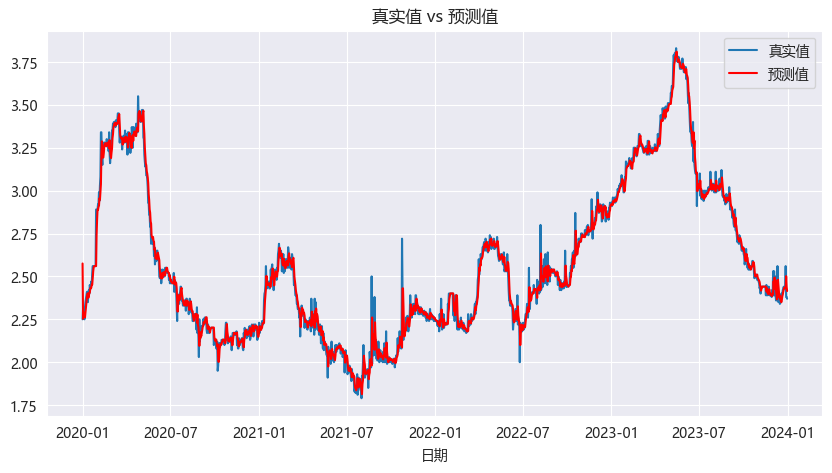

In [30]:
import matplotlib.pyplot as plt

# 假设 df 是包含真实值的 DataFrame，且已经包含了名为 'P' 的预测列
# 以下代码会画出真实值和预测值
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 例如使用微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法正常显示的问题

plt.figure(figsize=(10, 5))  # 设置图形大小
plt.plot(df['price'], label='真实值')  # 真实值
plt.plot(df['P'], color='red', label='预测值')  # 预测值

# 添加图例
plt.legend()

plt.title('真实值 vs 预测值')  # 图形标题
plt.xlabel('日期')  #
plt.savefig('./结果/折线图.png')
plt.show()

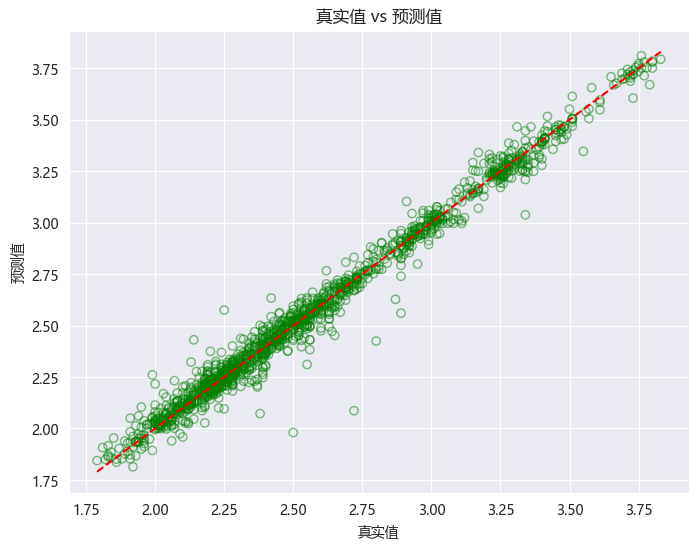

In [31]:
import matplotlib.pyplot as plt

# 绘制散点图，点为空心圆
plt.figure(figsize=(8, 6))
plt.scatter(df['price'], df['P'], edgecolor='green', facecolors='none', alpha=0.5)
plt.title('真实值 vs 预测值')
plt.xlabel('真实值')
plt.ylabel('预测值')

# 绘制45度线，表示完美预测的位置
plt.plot([df['price'].min(),df['price'].max()], [df['price'].min(), df['price'].max()], color='red', linestyle='--')
plt.savefig('./结果/散点图.png')
plt.show()

C:\Users\Ricco\anaconda3\envs\data_learn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


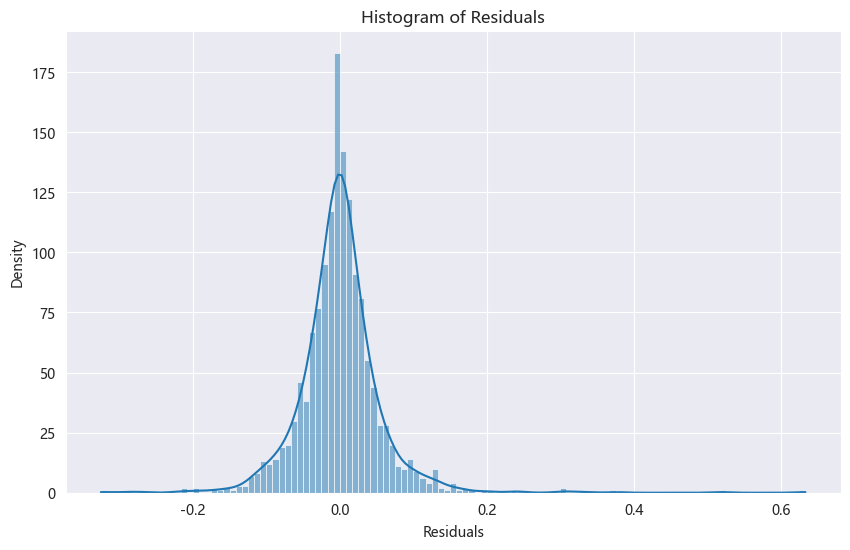

In [32]:
import seaborn as sns

# Since I cannot directly access the file content, I will simulate a residuals array for demonstration purposes.
# In practice, the user would use the actual residuals obtained from their model.

plt.figure(figsize=(10, 6))
sns.histplot(df['res'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()


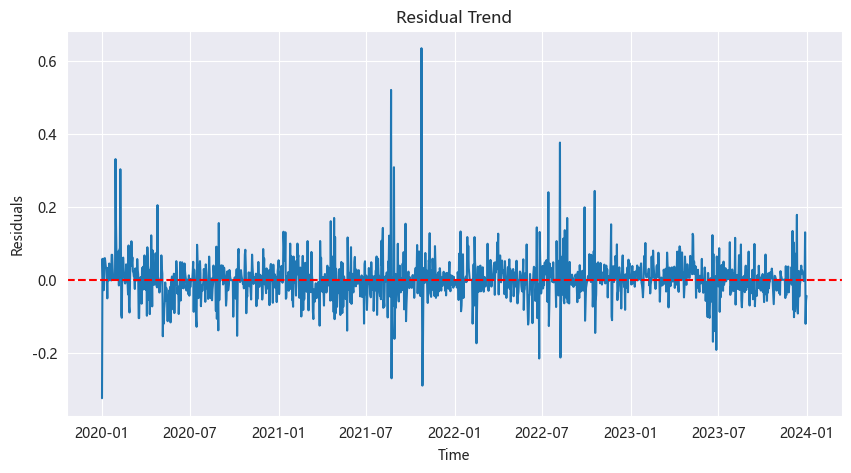

In [33]:
# 创建残差趋势图
plt.figure(figsize=(10, 5)) # 设置图形大小
plt.plot(df.index, df['res']) # 绘制残差
plt.title('Residual Trend') # 图表标题
plt.xlabel('Time') # x轴标签
plt.ylabel('Residuals') # y轴标签
plt.axhline(0, color='red', linestyle='--') # 绘制y=0的参考线
plt.show()

In [34]:
ADF_PP(df['res'])

ADF Test Result Summary:
ADF Statistic: -5.690094995985664
p-value: 8.108518780053874e-07
Number of Lags Used: 24
Number of Observations Used: 1436
Critical Values:
   1%, -3.434911997169608
   5%, -2.863554810504947
   10%, -2.567842671398422
Maximized Information Criterion (AIC): -4176.36749931494
Phillips-Perron Test for unit root
     Phillips-Perron Test (Z-tau)    
Test Statistic                -40.109
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<Figure size 640x480 with 0 Axes>

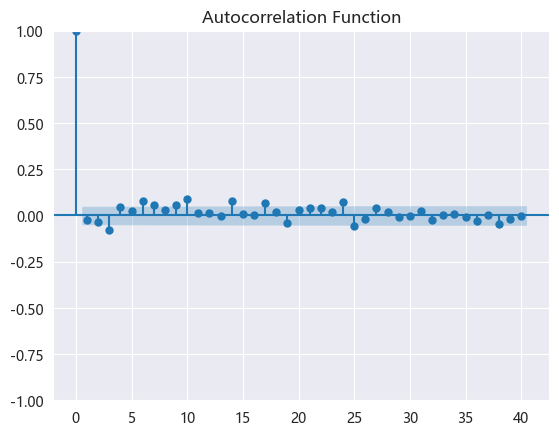

<Figure size 640x480 with 0 Axes>

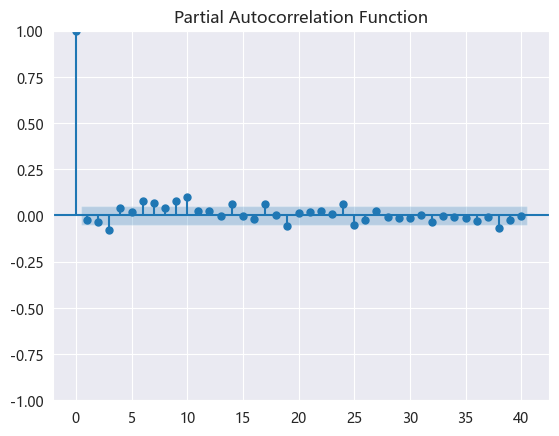

In [35]:
# 残差
# 绘制自相关图
plt.figure()
plot_acf(df['res'], lags=40)  # 可以通过lags参数调整显示的滞后数量
plt.title('Autocorrelation Function')

# 绘制偏自相关图
plt.figure()
plot_pacf(df['res'], lags=40)  # 同样可以调整滞后数量
plt.title('Partial Autocorrelation Function')

# 显示图形
plt.show()

In [36]:
zixiangguan_pianxiangguan(df['res'])

   LAG        AC       PAC
0    1 -0.021821 -0.021832
1    2 -0.036513 -0.036989
2    3 -0.078411 -0.080536
3    4  0.046485  0.042267
4    5  0.024009  0.020200
5    6  0.078301  0.077436
6    7  0.055793  0.069647
7    8  0.030902  0.043341
8    9  0.059312  0.079370
9   10  0.087501  0.101338
      lb_stat     lb_pvalue
1    0.697098  4.037605e-01
2    2.650272  2.657668e-01
3   11.663658  8.628792e-03
4   14.833713  5.058829e-03
5   15.679900  7.819955e-03
6   24.686515  3.902273e-04
7   29.262560  1.295729e-04
8   30.667363  1.609983e-04
9   35.845887  4.222208e-05
10  47.124312  8.963568e-07


In [37]:
import statsmodels.api as sm

# 假设df['res']是你的残差序列
# 对残差平方进行滞后5阶的回归，以检查ARCH效应
res_squared = df['res']**2
lags = 5

# 创建滞后变量
for i in range(1, lags + 1):
    df[f'res_lag_{i}'] = res_squared.shift(i)

# 构造滞后变量的DataFrame
lagged_res_squared = df[[f'res_lag_{i}' for i in range(1, lags + 1)]].dropna()

# 拟合线性回归模型
X = lagged_res_squared
y = res_squared[len(res_squared) - len(X):]
X = sm.add_constant(X)
lm_model = sm.OLS(y, X).fit()

# 输出回归结果
print(lm_model.summary())

# 计算LM统计量
lm_stat = lm_model.f_pvalue

# 输出LM统计量
print(f'LM Statistic p-value: {lm_stat}')


                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     7.071
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           1.53e-06
Time:                        19:40:12   Log-Likelihood:                 4066.0
No. Observations:                1456   AIC:                            -8120.
Df Residuals:                    1450   BIC:                            -8088.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.000      6.049      0.0

In [38]:
from statsmodels.stats.diagnostic import het_arch

# 假设df['res']是ARIMA模型的残差序列
test_result = het_arch(df['res'])

# 打印基本的检测结果
lm_value, lm_pvalue, fvalue, f_pvalue = test_result

print(f'LM Statistic: {lm_value}')
print(f'LM Test p-value: {lm_pvalue}')
print(f'F-Statistic: {fvalue}')
print(f'F-Test p-value: {f_pvalue}')

# 对残差序列的不同滞后阶数进行ARCH效应的LM检测
lags = [1, 2, 3, 4, 5]  # 你想要测试的滞后阶数列表
lm_values = []
lm_pvalues = []

for lag in lags:
    # 注意这里我们使用了'nlags'替换了弃用的'maxlag'
    result = het_arch(df['res'], nlags=lag)
    lm_values.append(result[0])
    lm_pvalues.append(result[1])

# 构建DataFrame
arch_test_df = pd.DataFrame({
    'lags(p)': lags,
    'chi2': lm_values,
    'p-value': lm_pvalues
})

# 设置自由度，这通常等于测试的滞后阶数
arch_test_df['df'] = arch_test_df['lags(p)']

# 计算Prob > chi2，het_arch函数已直接提供了p-value
arch_test_df['Prob > chi2'] = arch_test_df['p-value']

# 打印表格
print(arch_test_df)


LM Statistic: 42.92929925827792
LM Test p-value: 5.119874667802289e-06
F-Statistic: 4.390276063507082
F-Test p-value: 4.275910399301309e-06
   lags(p)       chi2       p-value  df   Prob > chi2
0        1  19.575926  9.667977e-06   1  9.667977e-06
1        2  33.276718  5.943639e-08   2  5.943639e-08
2        3  34.256085  1.749278e-07   3  1.749278e-07
3        4  34.437334  6.061002e-07   4  6.061002e-07
4        5  34.657556  1.760953e-06   5  1.760953e-06


In [39]:
print(garch_result.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             res_scaled   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -1181.05
Distribution:                  Normal   AIC:                           2372.10
Method:            Maximum Likelihood   BIC:                           2398.53
                                        No. Observations:                 1460
Date:                Wed, Feb 21 2024   Df Residuals:                     1458
Time:                        19:40:08   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0296  2.023e-02      1.462

In [40]:
import numpy as np
import pandas as pd

# 模拟ARIMA(3, 0, 0)过程的函数
def simulate_arima_once(T, ar_params, const, sigma2, initial_values):
    """
    单次模拟ARIMA(3, 0, 0)过程，并返回最终时期的价格。
    """
    Y = np.zeros(T)
    Y[:3] = initial_values
    epsilons = np.random.normal(0, np.sqrt(sigma2), T)
    
    for t in range(3, T):
        Y[t] = const + ar_params[0] * Y[t-1] + ar_params[1] * Y[t-2] + ar_params[2] * Y[t-3] + epsilons[t]
    
    return Y[-1]

# ARIMA模型参数
const = 2.5752
ar_params = [0.5426, 0.2643, 0.1881]
sigma2 = 0.0033

# 初始值，应替换为实际观察到的最后三个价格
initial_values = df['price'][-3:].tolist()

# 模拟的时间点数
T = 4

# 执行N次模拟
N = 10000  # 模拟次数
simulated_prices = np.array([simulate_arima_once(T, ar_params, const, sigma2, initial_values) for _ in range(N)])

# 计算分位数
quantiles = {
    '分位数': ['1%', '5%', '10%', '25%', '50%', '75%', '90%', '95%', '99%'],
    '分位数数值': np.percentile(simulated_prices, [1, 5, 10, 25, 50, 75, 90, 95, 99]),
    '最小值': np.min(simulated_prices)
}
quantiles_df = pd.DataFrame(quantiles)

# 计算其他统计量
stats = {
    '类别': ['Obs', 'Sum of Wgt.', 'Mean', 'Std. Dev.', 'Variance', 'Skewness', 'Kurtosis', '最大值'],
    '数值': [
        N, N, np.mean(simulated_prices), np.std(simulated_prices), np.var(simulated_prices),
        pd.Series(simulated_prices).skew(), pd.Series(simulated_prices).kurt(), np.max(simulated_prices)
    ]
}
stats_df = pd.DataFrame(stats).set_index('类别')

# 打印统计特征表
print("仿真模拟10000次价格统计特征表（单位：元/千克）")
print(quantiles_df)
print(stats_df)


仿真模拟10000次价格统计特征表（单位：元/千克）
   分位数     分位数数值       最小值
0   1%  4.807926  4.730074
1   5%  4.845647  4.730074
2  10%  4.865797  4.730074
3  25%  4.899632  4.730074
4  50%  4.938850  4.730074
5  75%  4.977027  4.730074
6  90%  5.012802  4.730074
7  95%  5.033455  4.730074
8  99%  5.076318  4.730074
                       数值
类别                       
Obs          10000.000000
Sum of Wgt.  10000.000000
Mean             4.939037
Std. Dev.        0.057466
Variance         0.003302
Skewness         0.064790
Kurtosis         0.008430
最大值              5.156154
